In [241]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})
pd.options.mode.chained_assignment = None  # default='warn'

In [243]:
#load data for researchers and divisions
df_researchers = pd.read_pickle("Files/Dataframes/researchersFinal.pkl") 
researchers = df_researchers.drop_duplicates(subset = ['SearchName', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)
divisionResearchers = df_researchers.drop_duplicates(subset = ['SearchName', 'Year', 'Division', 'SessionType']) #unique researchers, also wrt. division
errorResearchers = pd.read_pickle("Files/Dataframes/errorResearchers_filtered.pkl")
errorResearchers_gender = pd.read_pickle("Files/Dataframes/ResearchersNotFound_wGender.pkl")

In [244]:
researchers['log_MaxPaperCount'] = np.log2(researchers.MaxPaperCount)
researchers['log_CumulativePaperCount'] = np.log2(researchers.CumulativePaperCount)
researchers['log_Productivity'] = np.log2(researchers.Productivity)
researchers['log_AuthorCount'] = np.log2(researchers.AuthorCount)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


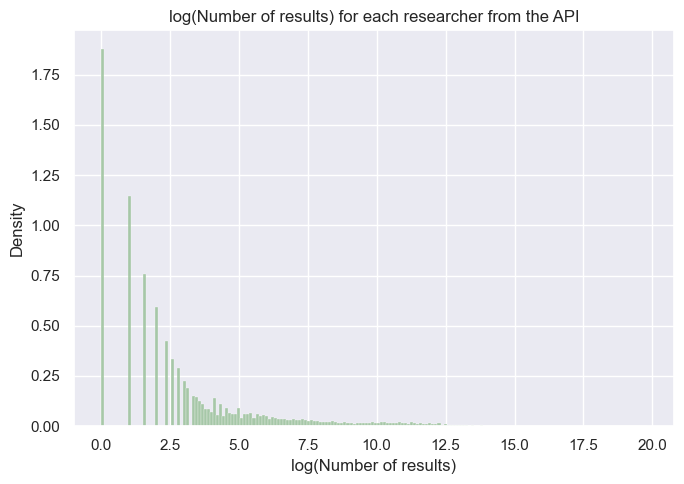

In [245]:
sns.histplot(data = researchers, x = 'log_AuthorCount', stat = 'density', color = 'darkseagreen')
plt.xlabel('log(Number of results)')
plt.title('log(Number of results) for each researcher from the API')
plt.tight_layout()
plt.savefig("Figures/authorCount.png", bbox_inches='tight')
plt.show()

### Field

In [246]:
field_API = (researchers.groupby('API_Field').count()/len(researchers)).sort_values(by ='ID', ascending = False).reset_index()
fields_external = (researchers.groupby('ExternalField').count()/len(researchers)).sort_values(by ='ID', ascending = False).reset_index()
fields_model = (researchers.groupby('ModelField').count()/len(researchers)).sort_values(by ='ID', ascending = False).reset_index()

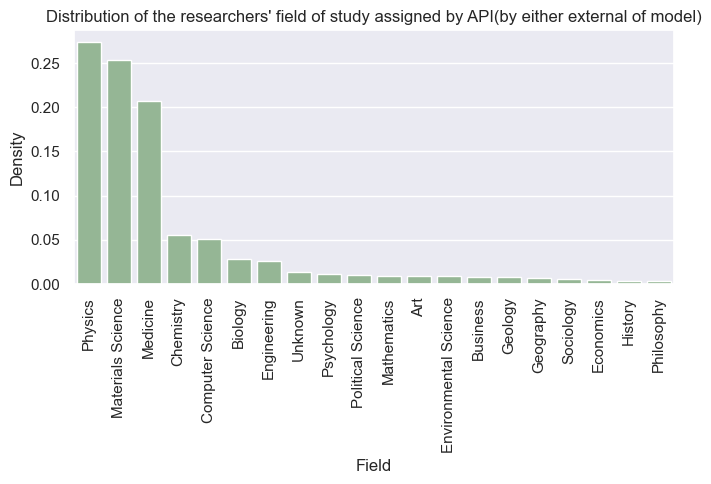

In [247]:
sns.barplot(data = field_API, x = 'API_Field', y = 'ID', color = 'darkseagreen')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Density')
plt.title("Distribution of the researchers' field of study assigned by API(by either external of model)")
plt.tight_layout()
plt.savefig("Figures/fieldPlot_API.png", bbox_inches='tight')
plt.show()

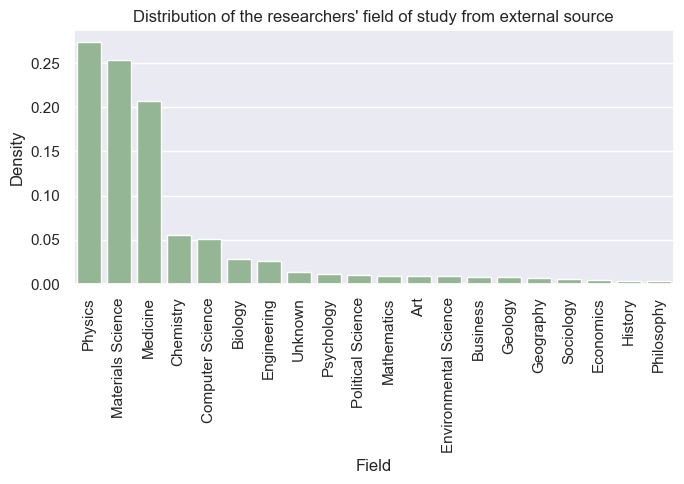

In [248]:
sns.barplot(data = fields_external, x = 'ExternalField', y = 'ID', color = 'darkseagreen')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Density')
plt.title("Distribution of the researchers' field of study from external source")
plt.tight_layout()
plt.savefig("Figures/fieldPlot_external.png", bbox_inches='tight')
plt.show()

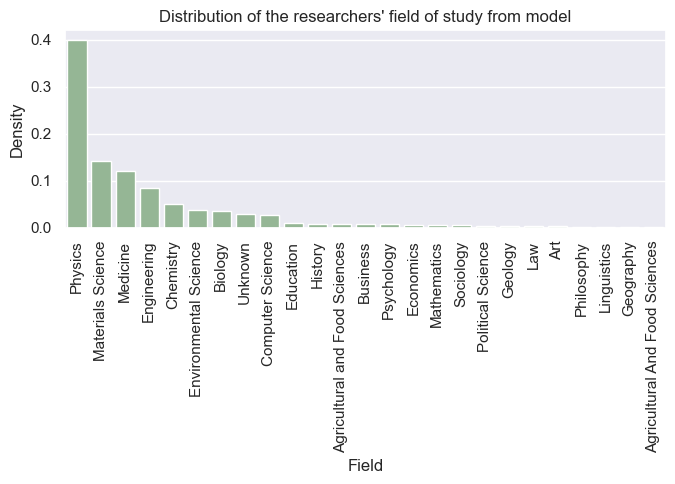

In [249]:
sns.barplot(data = fields_model, x = 'ModelField', y = 'ID', color = 'darkseagreen')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Density')
plt.title("Distribution of the researchers' field of study from model")
plt.tight_layout()
plt.savefig("Figures/fieldPlot_model.png", bbox_inches='tight')
plt.show()

In [250]:
researchers['SameField'] = np.where(researchers['ExternalField'] == researchers['ModelField'], 1, 0)

In [251]:
print("Share of researchers with same field from model and external sources:", len(researchers[researchers.SameField == 1])/len(researchers))

Share of researchers with same field from model and external sources: 0.5721463581443064


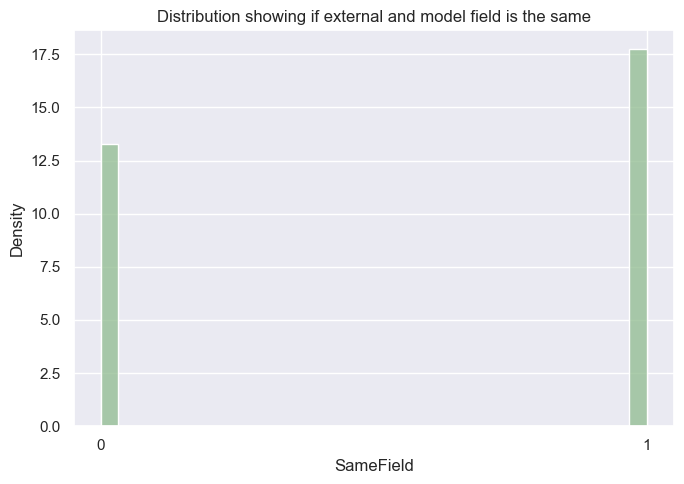

In [252]:
sns.histplot(data = researchers, x = 'SameField', stat = 'density', color = 'darkseagreen')
plt.xticks(np.arange(2))
plt.title('Distribution showing if external and model field is the same')
plt.tight_layout()
plt.savefig("Figures/sameField.png", bbox_inches='tight')
plt.show()

### Researchers within medicine

In [253]:
medicineResearchers_API = researchers[researchers.API_Field == 'Medicine'].reset_index()
medicineResearchers_external = researchers[researchers.ExternalField == 'Medicine'].reset_index()
medicineResearchers_model = researchers[researchers.ModelField == 'Medicine'].reset_index()

#print("Share of attendees with medicine as field:", medicineResearchers.groupby('SessionType').count()['ID']['attendee']/len(researchers[researchers.SessionType == 'attendee']))
#print("Share of invited speakers with medicine as field:", medicineResearchers.groupby('SessionType').count()['ID']['invited']/len(researchers[researchers.SessionType == 'invited']))

In [254]:
medicineResearchers_fieldCount_external = medicineResearchers_external.groupby('ExternalFieldCount').count().reset_index()
medicineResearchers_fieldCount_model = medicineResearchers_model.groupby('ModelFieldCount').count().reset_index()

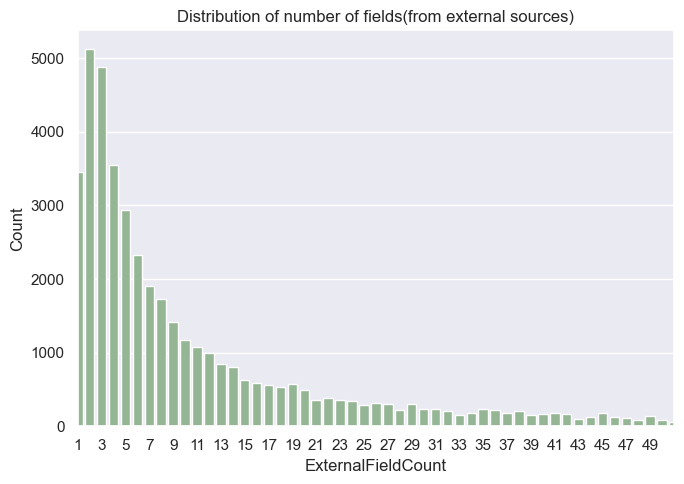

In [255]:
sns.barplot(data = medicineResearchers_fieldCount_external, x = 'ExternalFieldCount', y = 'ID', color = 'darkseagreen')
plt.xlim(0,50)
plt.xticks(np.arange(0,50, 2)) 
#plt.xlabel('Researcher index')
plt.ylabel('Count')
plt.title("Distribution of number of fields(from external sources)")
plt.tight_layout()
plt.savefig("Figures/fieldCount_medicine_external.png", bbox_inches='tight')
plt.show()

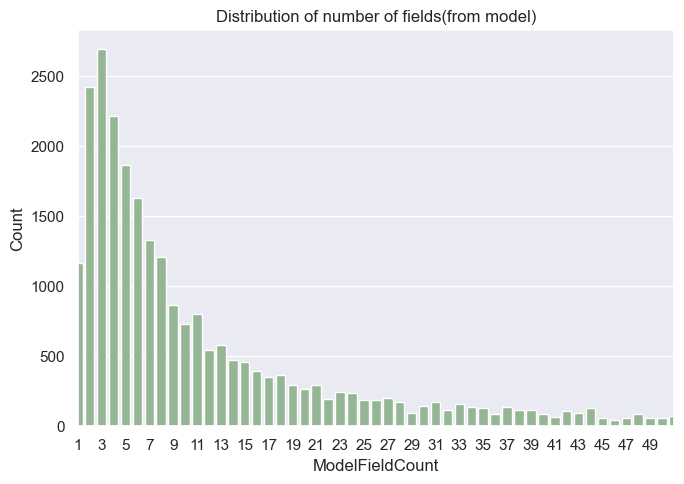

In [256]:
sns.barplot(data = medicineResearchers_fieldCount_model, x = 'ModelFieldCount', y = 'ID', color = 'darkseagreen')
plt.xlim(0,50)
plt.xticks(np.arange(0,50, 2)) 
#plt.xlabel('Researcher index')
plt.ylabel('Count')
plt.title("Distribution of number of fields(from model)")
plt.tight_layout()
plt.savefig("Figures/fieldCount_Model.png", bbox_inches='tight')
plt.show()

## Plots

In [357]:
#it seems to be decreasing problem with negative seniority. 
#Find a better way to test it and then plot it. 
negativeSeniority = researchers[researchers.Seniority < 0]
#negativeSeniority.groupby('Year').count()

In [336]:
yearList = researchers.groupby('Year').count().ID.to_list()
yearList

[4647,
 5269,
 7041,
 7305,
 7650,
 8354,
 8072,
 11573,
 10997,
 11801,
 12008,
 12974,
 13071,
 15851,
 16509,
 16491,
 16710,
 15954,
 17048]

In [340]:
a =researchers[researchers.Seniority < 0].groupby('Year').count().ID.to_list()
#.div(yearList)
#/yearList

In [343]:
for i in range(0,len(a)):
    print(a[i]/yearList[i])

0.22207876049063913
0.2089580565572215
0.18250248544240874
0.17700205338809036
0.15869281045751635
0.14400287287526933
0.12685827552031714
0.11025663181543247
0.09075202327907611
0.08414541140581307
0.07220186542305129
0.05433944812702328
0.04391400810955551
0.03532900132483755
0.025561814767702466
0.018737493178097146
0.014063435068821066
0.0066441017926538795


In [303]:
#14313/len(attendees)
884/len(invited)


#Negative seniority: same for sessionType, 

0.08359338061465721

In [257]:
invited = researchers[researchers.SessionType == 'invited']
attendees = researchers[researchers.SessionType == 'attendee'] #change this to == 'participant'

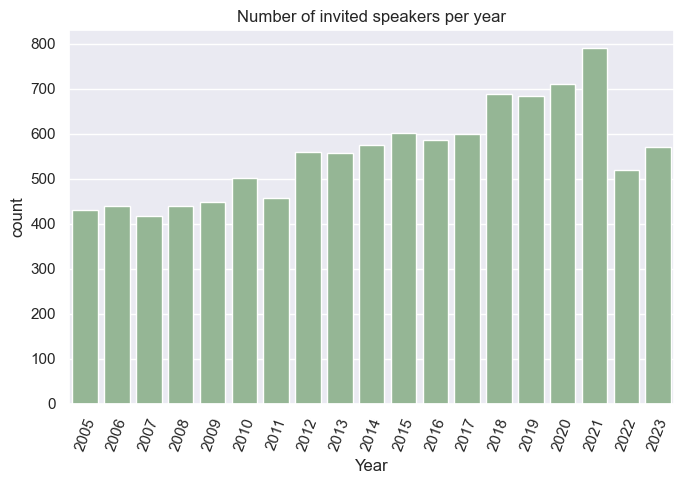

In [258]:
sns.countplot(x = 'Year', data = invited , color = 'darkseagreen')
plt.xticks(rotation=70)
plt.title('Number of invited speakers per year')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers.png", bbox_inches='tight')
plt.show()

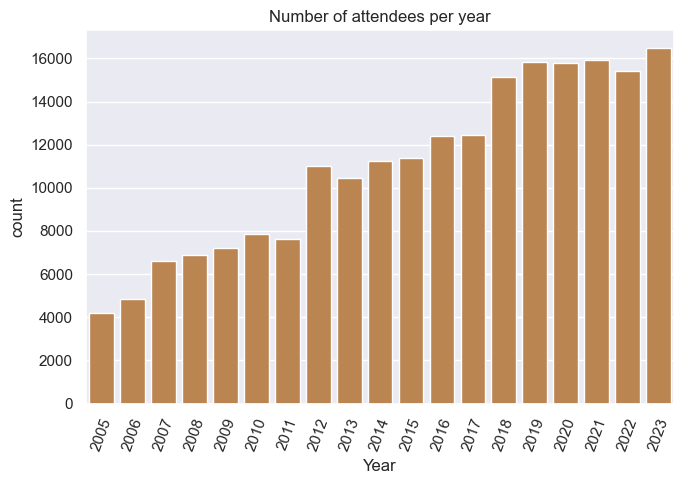

In [259]:
sns.countplot(x = 'Year', data = attendees , color = 'peru')
plt.xticks(rotation=70)
plt.title('Number of attendees per year')
plt.tight_layout()
plt.savefig("Figures/participants.png", bbox_inches='tight')
plt.show()

### Researcher not found

In [260]:
errorResearchers_inv = errorResearchers[errorResearchers.SessionType == 'invited']
errorResearchers_att = errorResearchers[errorResearchers.SessionType == 'attendee']

In [261]:
errorResearchersGender_inv = errorResearchers_gender[errorResearchers_gender.SessionType == 'invited']
errorResearchersGender_att = errorResearchers_gender[errorResearchers_gender.SessionType == 'attendee']

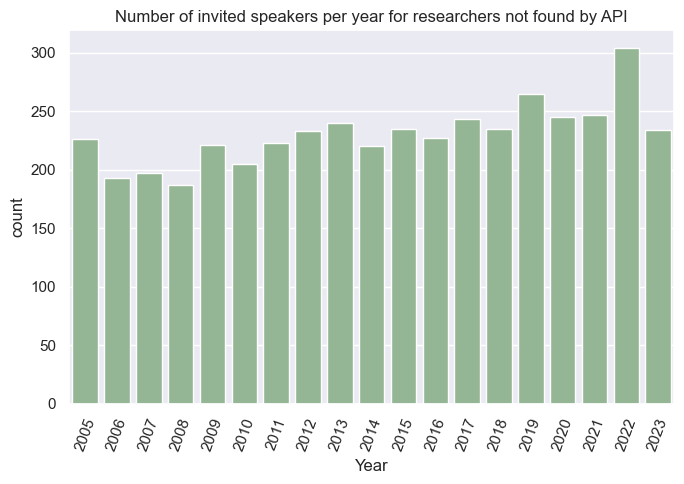

In [263]:
sns.countplot(x = 'Year', data = errorResearchers_inv , color = 'darkseagreen')
plt.xticks(rotation=70)
plt.title('Number of invited speakers per year for researchers not found by API')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers_errorResearchers.png", bbox_inches='tight')
plt.show()

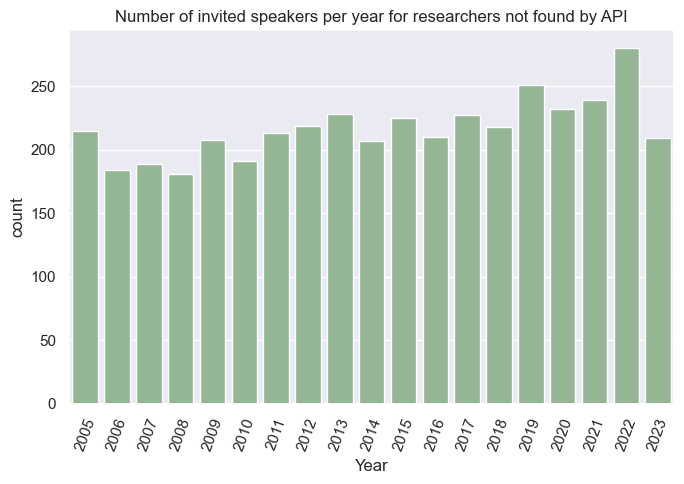

In [265]:
sns.countplot(x = 'Year', data = errorResearchersGender_inv , color = 'darkseagreen')
plt.xticks(rotation=70)
plt.title('Number of invited speakers per year for researchers not found by API')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers_errorResearchersGender.png", bbox_inches='tight')
plt.show()

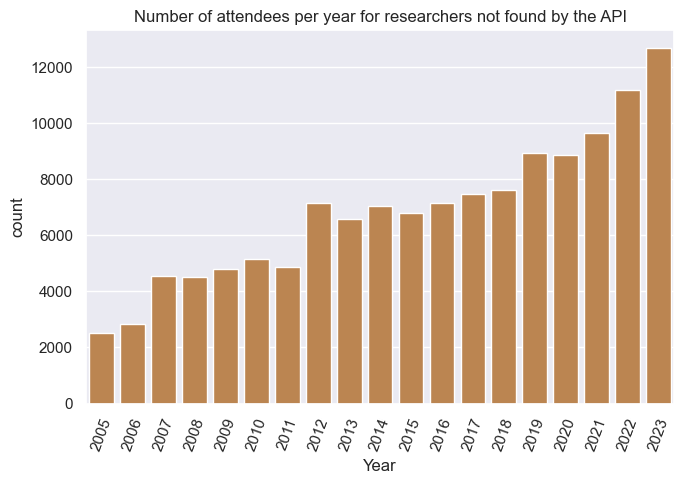

In [266]:
sns.countplot(x = 'Year', data = errorResearchers_att , color = 'peru')
plt.xticks(rotation=70)
plt.title('Number of attendees per year for researchers not found by the API')
plt.tight_layout()
plt.savefig("Figures/participants_errorResearchers.png", bbox_inches='tight')
plt.show()

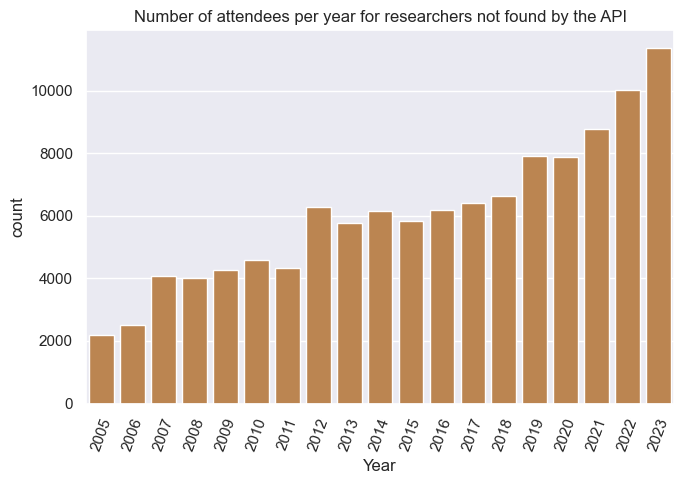

In [267]:
sns.countplot(x = 'Year', data = errorResearchersGender_att , color = 'peru')
plt.xticks(rotation=70)
plt.title('Number of attendees per year for researchers not found by the API')
plt.tight_layout()
plt.savefig("Figures/participants_errorResearchersGender.png", bbox_inches='tight')
plt.show()

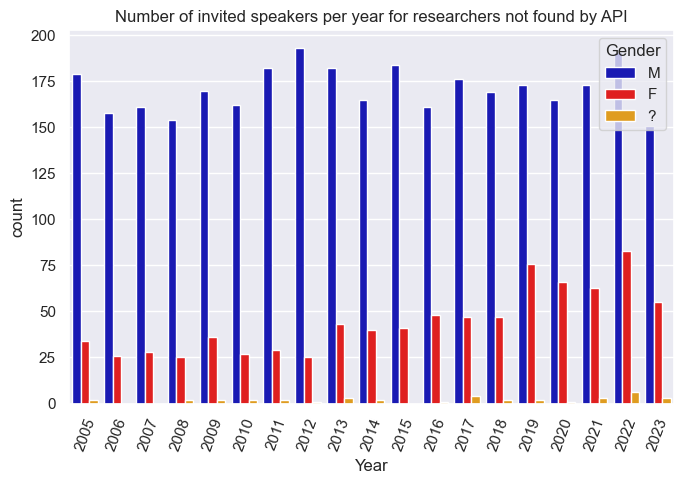

In [297]:
sns.countplot(x = 'Year', data = errorResearchersGender_inv , palette = ['mediumblue', 'red', 'orange'], hue = 'Gender')
plt.xticks(rotation=70)
plt.title('Number of invited speakers per year for researchers not found by API')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers_errorResearchersGenderShown.png", bbox_inches='tight')
plt.show()

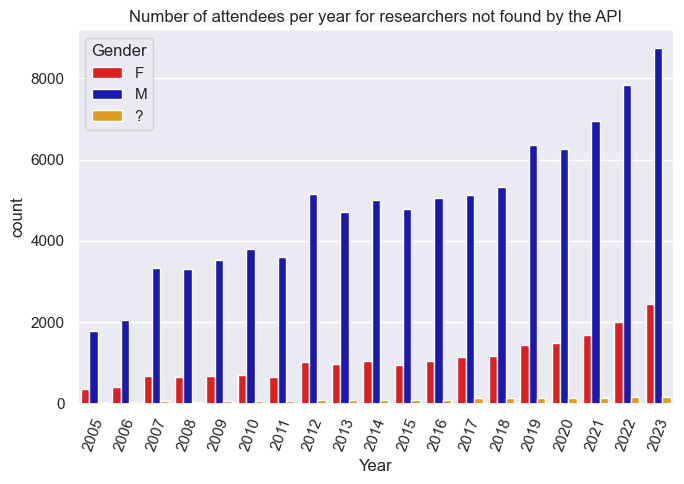

In [295]:
sns.countplot(x = 'Year', data = errorResearchersGender_att , palette = ['red', 'mediumblue', 'orange'], hue = 'Gender')
plt.xticks(rotation=70)
plt.title('Number of attendees per year for researchers not found by the API')
plt.tight_layout()
plt.savefig("Figures/participants_errorResearchersGenderShown.png", bbox_inches='tight')
plt.show()

In [268]:
invited_divisions = divisionResearchers[divisionResearchers.SessionType == 'invited']
attendees_divisions = divisionResearchers[divisionResearchers.SessionType == 'attendee']

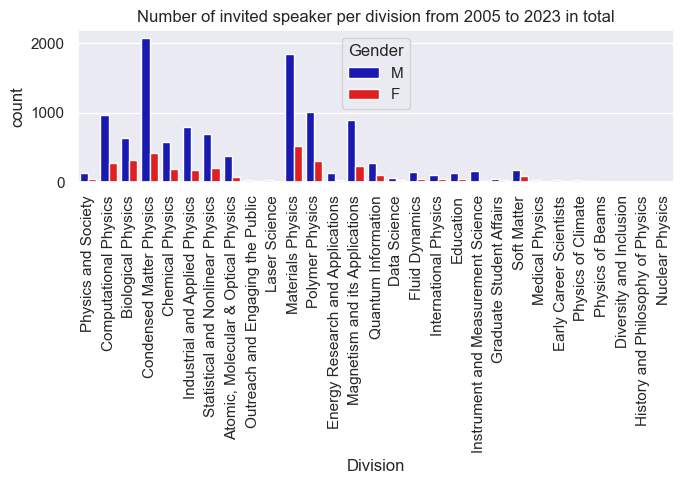

In [269]:
sns.countplot(x = 'Division', data = invited_divisions , hue = 'Gender', palette=["mediumblue", "red"])
plt.xticks(rotation=90)
plt.xlabel('Division')
plt.title('Number of invited speaker per division from 2005 to 2023 in total')
plt.tight_layout()
plt.savefig("Figures/invited_divisions.png", bbox_inches='tight')
plt.show()

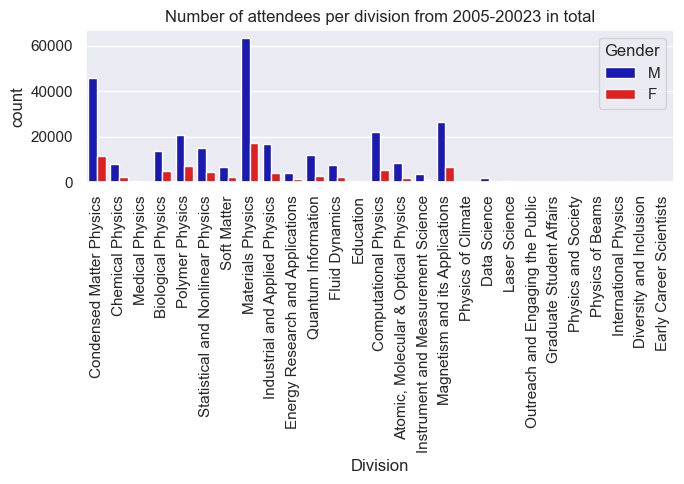

In [270]:
sns.countplot(x = 'Division', data = attendees_divisions, hue = 'Gender', palette=["mediumblue", "red"])
plt.xticks(rotation=90)
plt.xlabel('Division')
plt.title('Number of attendees per division from 2005-20023 in total')
plt.tight_layout()
plt.savefig("Figures/participants_divisions.png", bbox_inches='tight')
plt.show()

In [271]:
#calculate gender ratio
genderRatio_invited = pd.crosstab(index=invited.Year,
                             columns=invited.Gender,
                             normalize="index").rename(columns = {'F': 'Female invited', 'M': 'Male invited'})

genderRatio_attendees = pd.crosstab(index=attendees.Year,
                             columns=attendees.Gender,
                             normalize="index").rename(columns = {'F': 'Female attendees', 'M': 'Male attendees'})

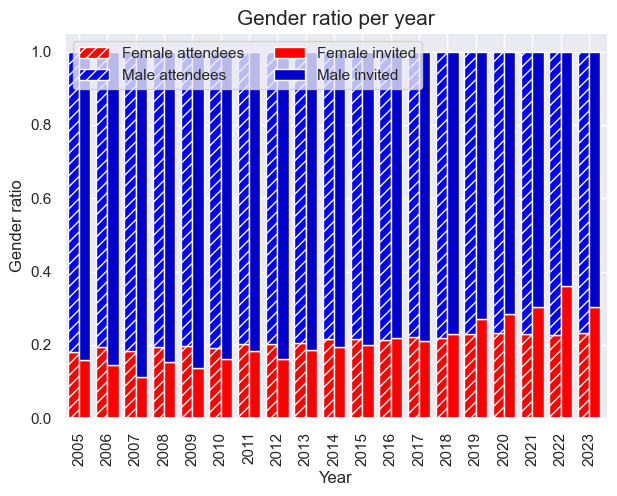

In [272]:
fig, ax = plt.subplots()
genderRatio_attendees.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['red', 'blue'], hatch = '///')
genderRatio_invited.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['red', "mediumblue"])
#ax.set_xlim(right=len(genderRatio_invited)-0.5)
ax.set_xlim(left=-0.5)
#ax.set_edgecolor(color = 'black')
plt.legend(loc="upper left", ncol = 2)
plt.title("Gender ratio per year", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio.png", bbox_inches='tight')
plt.show()

In [273]:
divGenderRatio_invited = pd.crosstab(index=invited_divisions.Division,
                             columns=invited_divisions.Gender,
                             normalize="index").rename(columns = {'F': 'Female invited', 'M': 'Male invited'})

divGenderRatio_participants = pd.crosstab(index=attendees_divisions.Division,
                             columns=attendees_divisions.Gender,
                             normalize="index").rename(columns = {'F': 'Female attendees', 'M': 'Male attendees'})

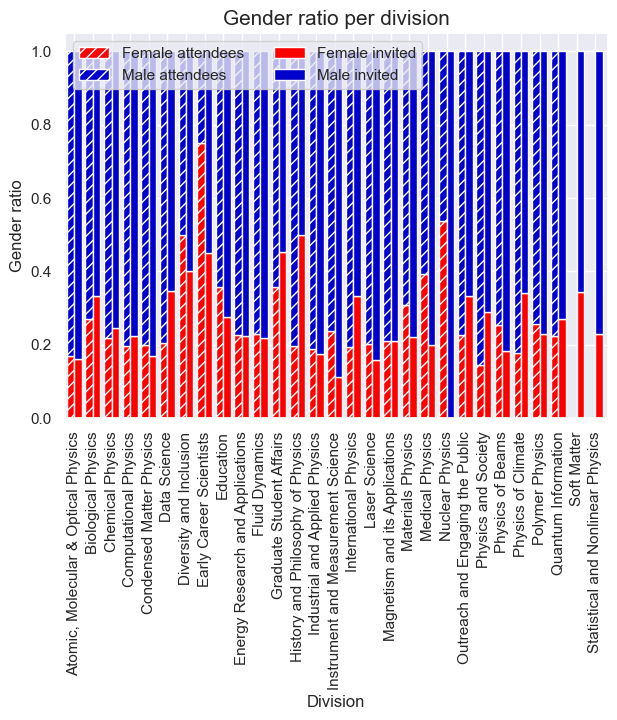

In [274]:
fig, ax = plt.subplots()
divGenderRatio_participants.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['red', 'mediumblue'], hatch = '///')
divGenderRatio_invited.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['red', "mediumblue"])
ax.set_xlim(left=-0.5)
plt.legend(loc="upper left", ncol = 2)
plt.title("Gender ratio per division", fontsize = 15)
plt.xlabel("Division")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio_Divisions.png", bbox_inches='tight')
plt.show()

In [275]:
invitedSpeakers_genderCount = invited.groupby(['Year', 'Gender']).count().reset_index()
participants_genderCount = attendees.groupby(['Year', 'Gender']).count().reset_index()

In [276]:
#get lineplot to show int as in data and not 
years = invitedSpeakers_genderCount.Year.unique().tolist()

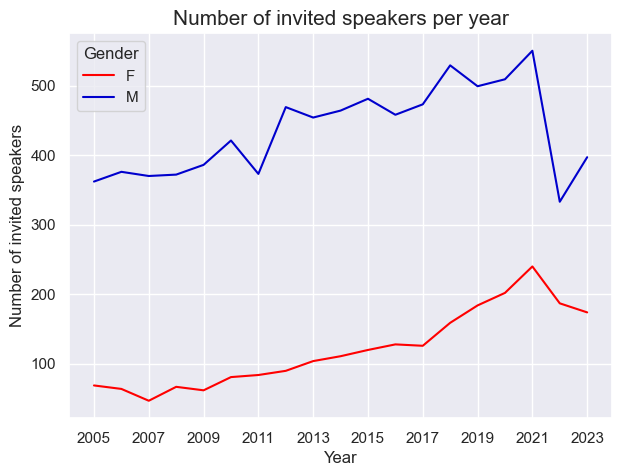

In [277]:
sns.lineplot(data = invitedSpeakers_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=['red', 'mediumblue'])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of invited speakers", fontsize=12)
plt.title("Number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/nInvitedSpeakers.png", bbox_inches='tight')
plt.show()

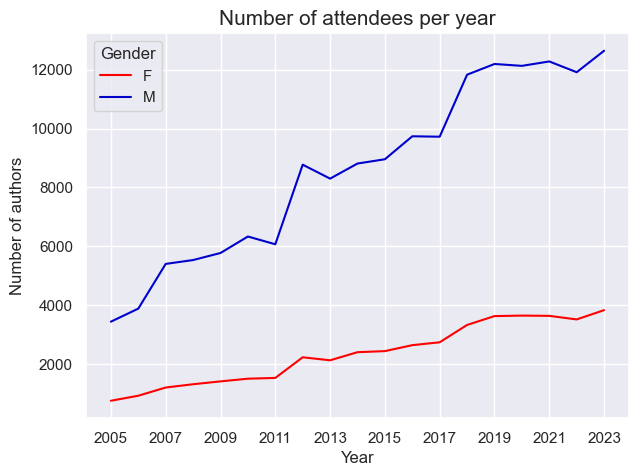

In [278]:
sns.lineplot(data = participants_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=["red", "mediumblue"])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of authors", fontsize=12)
plt.title("Number of attendees per year", fontsize = 15)
plt.savefig("Figures/nParticipants.png", bbox_inches='tight')
plt.show()

In [279]:
#calculate percentage increase
invitedSpeakers_genderCount_F = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'F']
invitedSpeakers_genderCount_M = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'M']
participants_genderCount_F = participants_genderCount[participants_genderCount.Gender == 'F']
participants_genderCount_M = participants_genderCount[participants_genderCount.Gender == 'M']

#calculate and add the increase
invitedSpeakers_genderCount_F['Increase'] = invitedSpeakers_genderCount_F.ID.pct_change().fillna(0) * 100
invitedSpeakers_genderCount_M['Increase'] = invitedSpeakers_genderCount_M.ID.pct_change().fillna(0) * 100
participants_genderCount_F['Increase'] = participants_genderCount_F.ID.pct_change().fillna(0) * 100
participants_genderCount_M['Increase'] = participants_genderCount_M.ID.pct_change().fillna(0) * 100

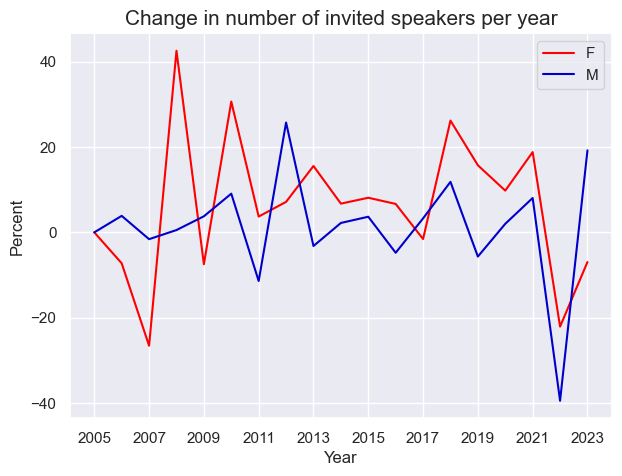

In [280]:
sns.lineplot(data = invitedSpeakers_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'F')
sns.lineplot(data = invitedSpeakers_genderCount_M, x = 'Year', y = 'Increase', color = 'mediumblue', label = 'M')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/invited_change.png", bbox_inches='tight')
plt.show()

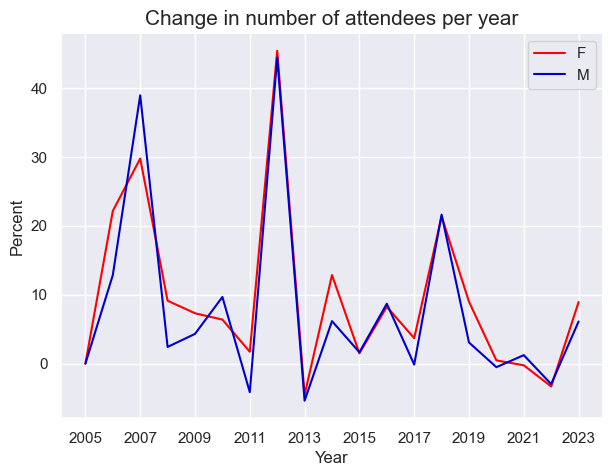

In [281]:
sns.lineplot(data = participants_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'F')
sns.lineplot(data = participants_genderCount_M, x = 'Year', y = 'Increase', color = 'mediumblue', label = 'M')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of attendees per year", fontsize = 15)
plt.savefig("Figures/attendees_change.png", bbox_inches='tight')
plt.show()

In [282]:
invDiv_gender = invited[invited.Division == 'FOEP'].groupby(['Year', 'Gender']).count().reset_index()
attDiv_gender = attendees[attendees.Division == 'FOEP'].groupby(['Year', 'Gender']).count().reset_index()

In [283]:
#change over time with FDI
print("Largest:", divGenderRatio_invited['Female invited'].nlargest(n=2))
print("Smallest:", divGenderRatio_invited['Female invited'].nsmallest(n=3))
#FDI, FGSA, DPB, FHPP, FOEP

#FDI: only one, so not worth looking at
#FGSA: too few
#DPB: too few
#FHPP: too few

#find someone else with many females, with more data

Largest: Division
History and Philosophy of Physics    0.500000
Graduate Student Affairs             0.452055
Name: Female invited, dtype: float64
Smallest: Division
Nuclear Physics                       0.000000
Instrument and Measurement Science    0.112903
Laser Science                         0.157895
Name: Female invited, dtype: float64


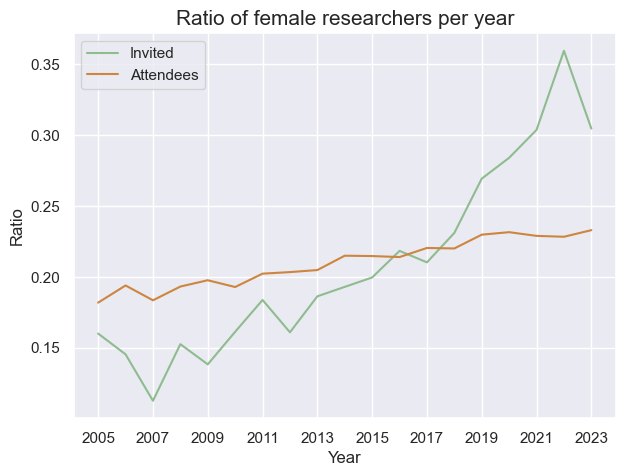

In [284]:
sns.lineplot(data = genderRatio_invited.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = genderRatio_attendees.reset_index(), x = 'Year', y = 'Female attendees', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.title("Ratio of female researchers per year", fontsize = 15)
plt.savefig("Figures/FemaleRatio.png", bbox_inches='tight')
plt.show()

In [285]:
#show ratio of some specific fields

### Publications

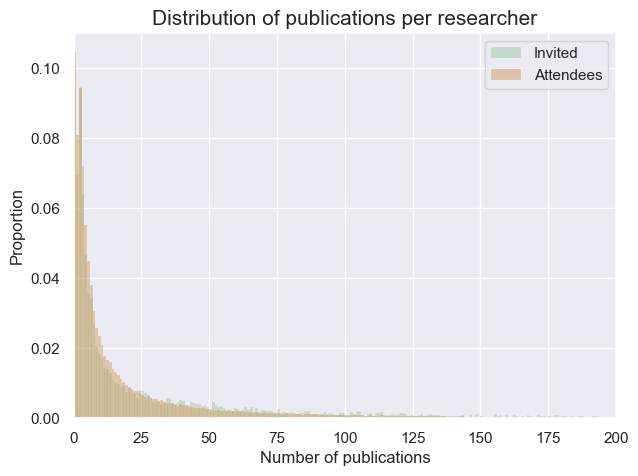

In [286]:
sns.histplot(data = invited, x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.4, binwidth = 1)
sns.histplot(data = attendees, x = 'CumulativePaperCount', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.4, binwidth = 1)
plt.legend()
plt.xlim(0, 200)
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per researcher", fontsize = 15)
plt.savefig("Figures/publications_dist_all.png", bbox_inches='tight')
plt.show()

In [229]:
len(att23[att23.CumulativePaperCount == 0])/len(att23)

0.007829095102263761

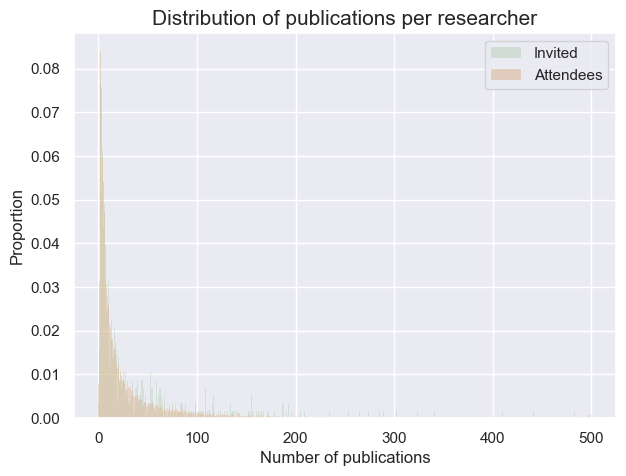

In [238]:
#publication for 2023
inv23 = invited[invited.Year == 2023]
att23 = attendees[attendees.Year == 2023]

sns.histplot(data = inv23 , x = 'CumulativePaperCount', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.3, binwidth = 1)
sns.histplot(data = att23, x = 'CumulativePaperCount', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.3, binwidth = 1)
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per researcher", fontsize = 15)
plt.show()

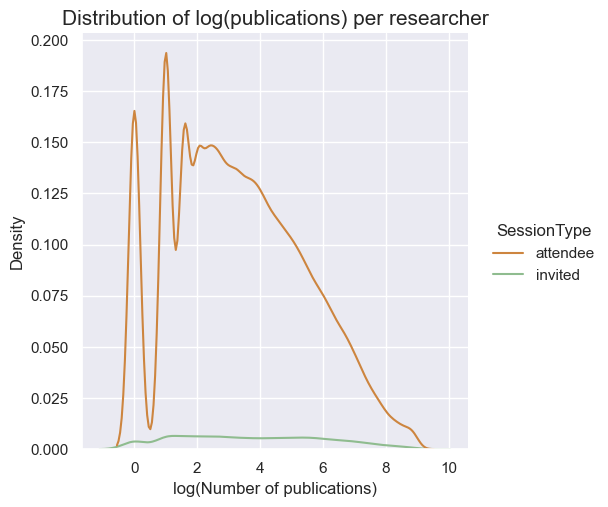

In [215]:
sns.displot(researchers, x = 'log_CumulativePaperCount', kind = 'kde', hue = 'SessionType', palette = ['peru', 'darkseagreen'])
plt.xlabel("log(Number of publications)", fontsize=12)
plt.title("Distribution of log(publications) per researcher", fontsize = 15)
plt.savefig("Figures/logPublications_dist_all.png", bbox_inches='tight')
plt.show()

In [216]:
maleInv = invited[invited.Gender == 'M']
femaleInv = invited[invited.Gender == 'F']
maleAtt = attendees[attendees.Gender == 'M']
femaleAtt = attendees[attendees.Gender == 'F']

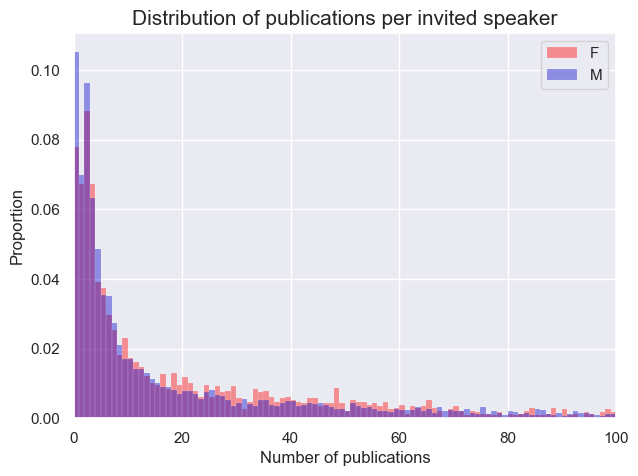

In [361]:
#same plot as the one above
sns.histplot(data = femaleInv, x = 'CumulativePaperCount', stat = 'proportion', color = 'red', label = 'F', binwidth = 1, alpha = 0.4)
sns.histplot(data = maleInv, x = 'CumulativePaperCount', stat = 'proportion', color = 'mediumblue', label = 'M', binwidth = 1, alpha = 0.4)
plt.xlim(0, 100)
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per invited speaker", fontsize = 15)
plt.savefig("Figures/publications_dist_invited.png", bbox_inches='tight')
plt.show()

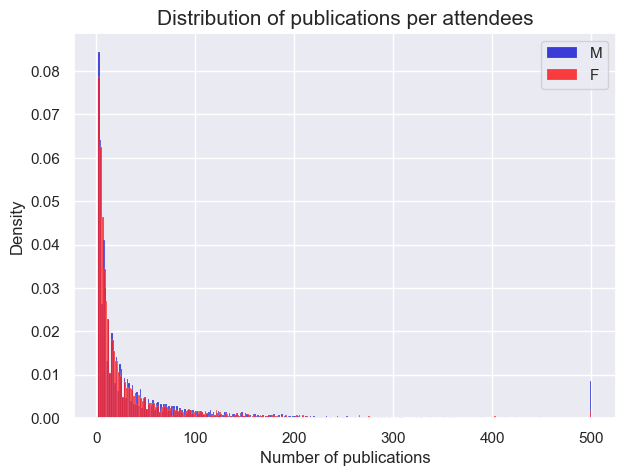

In [112]:
sns.histplot(data = maleAtt, x = 'MaxPaperCount', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleAtt, x = 'MaxPaperCount', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per attendees", fontsize = 15)
plt.savefig("Figures/publications_dist_attendees.png", bbox_inches='tight')
plt.show()

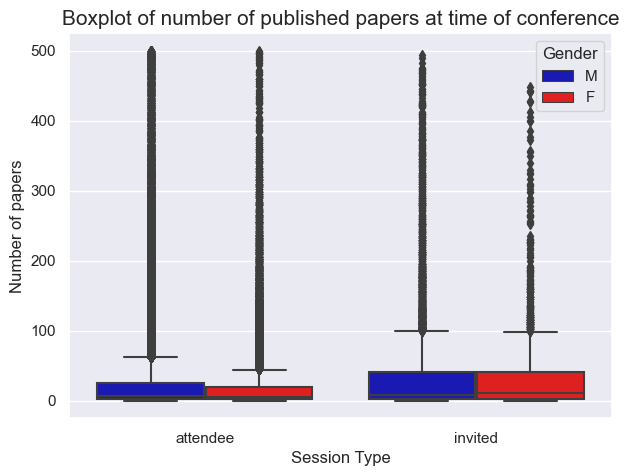

In [113]:
#boxplot of maxPaperCount
sns.boxplot(data=researchers, x="SessionType", y="CumulativePaperCount", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Number of papers", fontsize=12)
plt.title("Boxplot of number of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/maxPaperCount_boxplot", bbox_inches='tight')
plt.show()

In [114]:
#should plot below be cut off at y for negative values?

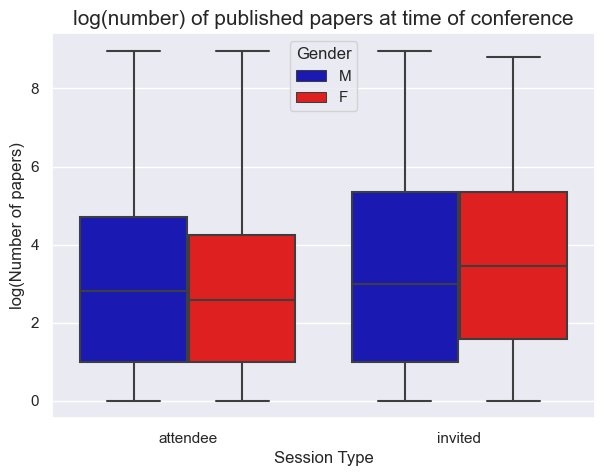

In [115]:
#boxplot of maxPaperCount
sns.boxplot(data=researchers, x="SessionType", y="log_CumulativePaperCount", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("log(Number of papers)", fontsize=12)
plt.title("log(number) of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/maxPaperCount_boxplot", bbox_inches='tight')
plt.show()

#not #not containing researchers not publishing anything

In [116]:
bins = np.arange(0, 35, 5).tolist()
bins.append(float("inf"))
labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '> 30']

In [117]:
#create seniority categories
researchers['Seniority_cat'] = pd.cut(researchers['Seniority'], bins = bins, labels = labels)

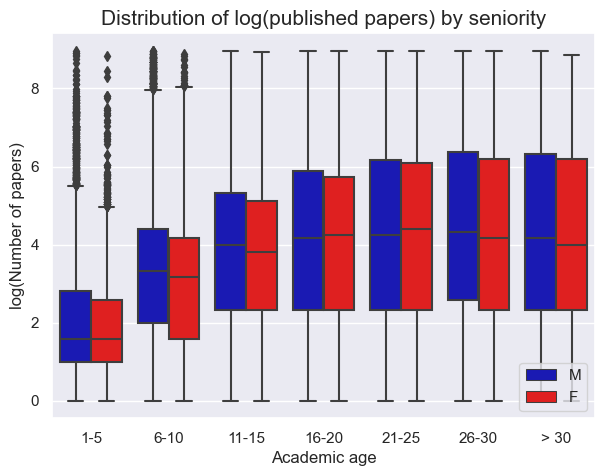

In [118]:
sns.boxplot(data=researchers , x="Seniority_cat", y='log_CumulativePaperCount', hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("log(Number of papers)", fontsize=12)
plt.title("Distribution of log(published papers) by seniority", fontsize = 15)
plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_Seniority_boxplot", bbox_inches='tight')
plt.show()

In [119]:
### distribution(by histogram) of publications for invited speakers(male and female and female indicated) for a few divisions

### Seniority

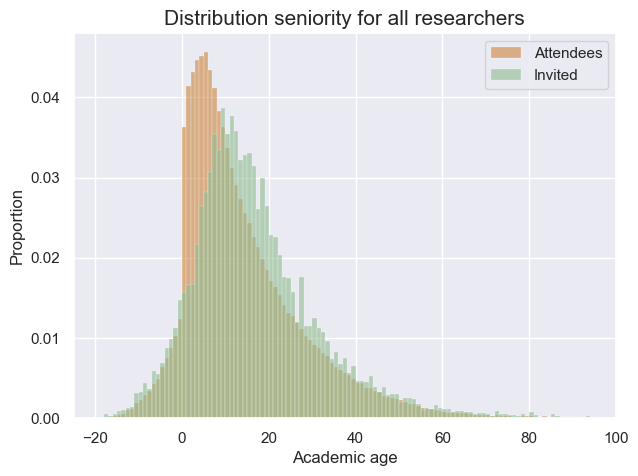

In [358]:
#distribution of seniority
sns.histplot(data = attendees, x = 'Seniority', stat = 'proportion', color = 'peru', label = 'Attendees', alpha = 0.6, binwidth = 1)
sns.histplot(data = invited, x = 'Seniority', stat = 'proportion', color = 'darkseagreen', label = 'Invited', alpha = 0.6, binwidth = 1)
plt.xlim(-25, 100)
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for all researchers", fontsize = 15)
plt.savefig("Figures/seniorityDist_all.png", bbox_inches='tight')
plt.show()

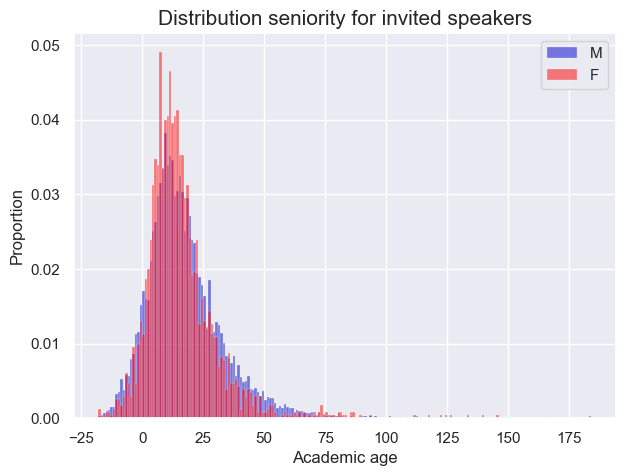

In [363]:
sns.histplot(data = maleInv , x = 'Seniority', stat = 'proportion', color = 'mediumblue', label = 'M', alpha = 0.5, binwidth = 1)
sns.histplot(data = femaleInv, x = 'Seniority', stat = 'proportion', color = 'red', label = 'F', alpha = 0.5, binwidth = 1)
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for invited speakers", fontsize = 15)
plt.savefig("Figures/seniorityDist_Invited.png", bbox_inches='tight')
plt.show()

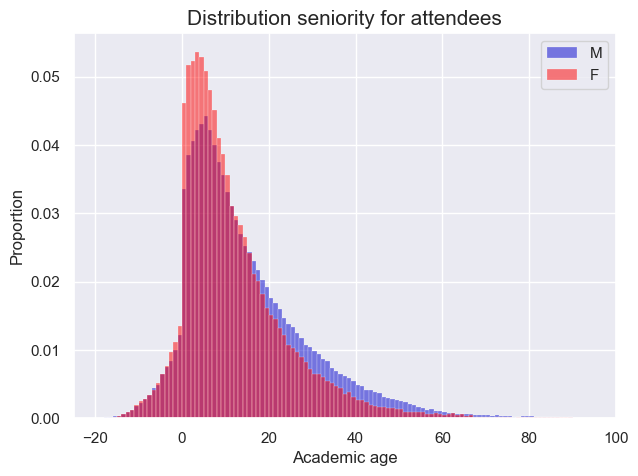

In [364]:
sns.histplot(data = maleAtt , x = 'Seniority', stat = 'proportion', color = 'mediumblue', label = 'M', alpha = 0.5, binwidth = 1)
sns.histplot(data = femaleAtt, x = 'Seniority', stat = 'proportion', color = 'red', label = 'F', alpha = 0.5, binwidth = 1)
plt.legend()
plt.xlim(-25, 100)
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for attendees", fontsize = 15)
plt.savefig("Figures/seniorityDist_Attendees.png", bbox_inches='tight')
plt.show()

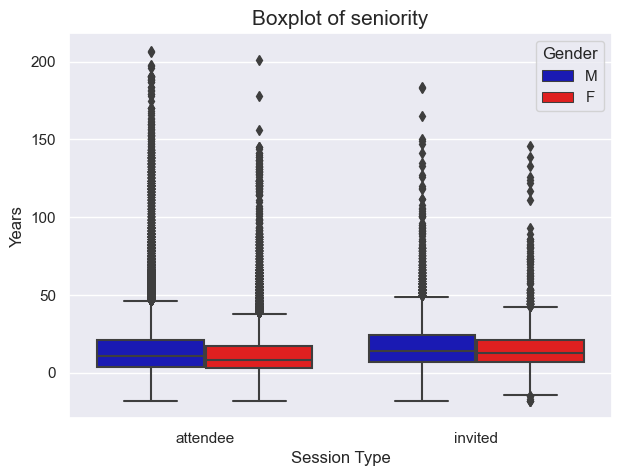

In [131]:
#boxplot of seniority
sns.boxplot(data=researchers , x="SessionType", y="Seniority", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Years", fontsize=12)
plt.title("Boxplot of seniority", fontsize = 15)
plt.savefig("Figures/seniority_boxplot", bbox_inches='tight')
plt.show()

### Productivity

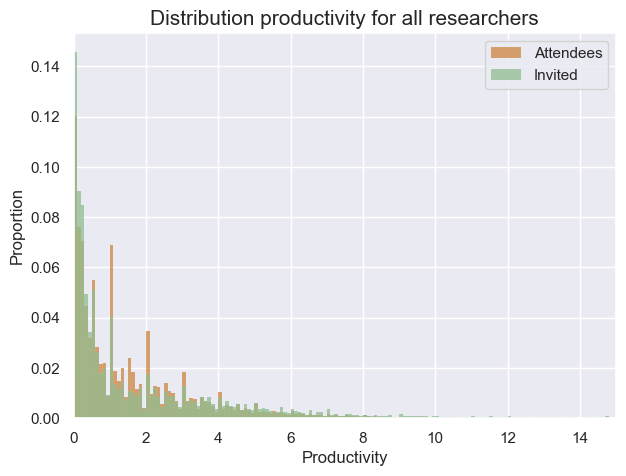

In [368]:
sns.histplot(data = attendees, x = 'Productivity', stat = 'proportion', color = 'peru', label = 'Attendees', binwidth = 0.1)
sns.histplot(data = invited, x = 'Productivity', stat = 'proportion', color = 'darkseagreen', label = 'Invited', binwidth = 0.1)
plt.legend()
plt.xlim(0, 15)
plt.title("Distribution productivity for all researchers", fontsize = 15)
plt.savefig("Figures/productivityDist_all.png", bbox_inches='tight')
plt.show()

#invited: darkseagreen
#attendees: peru

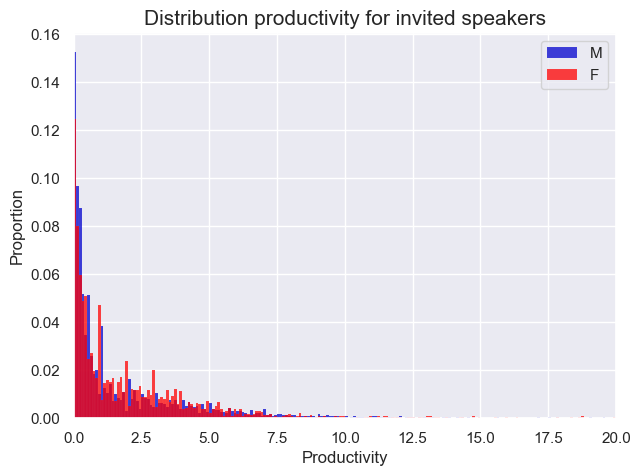

In [369]:
sns.histplot(data = maleInv , x = 'Productivity', stat = 'proportion', color = 'mediumblue', label = 'M', binwidth = 0.1)
sns.histplot(data = femaleInv, x = 'Productivity', stat = 'proportion', color = 'red', label = 'F', binwidth = 0.1)
plt.legend()
plt.xlim(0,20)
plt.title("Distribution productivity for invited speakers", fontsize = 15)
plt.savefig("Figures/productivityDist_Invited.png", bbox_inches='tight')
plt.show()

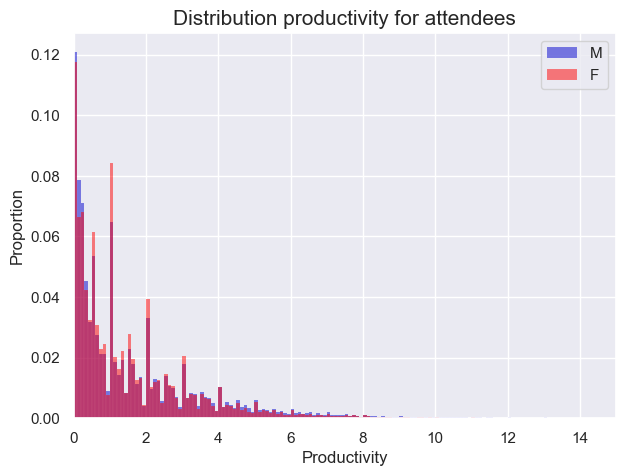

In [370]:
sns.histplot(data = maleAtt , x = 'Productivity', stat = 'proportion', color = 'mediumblue', label = 'M', alpha = 0.5, binwidth = 0.1)
sns.histplot(data = femaleAtt, x = 'Productivity', stat = 'proportion', color = 'red', label = 'F', alpha = 0.5, binwidth = 0.1)
plt.legend()
plt.xlim(0,15)
plt.title("Distribution productivity for attendees", fontsize = 15)
plt.savefig("Figures/productivityDist_Attendees.png", bbox_inches='tight')
plt.show()

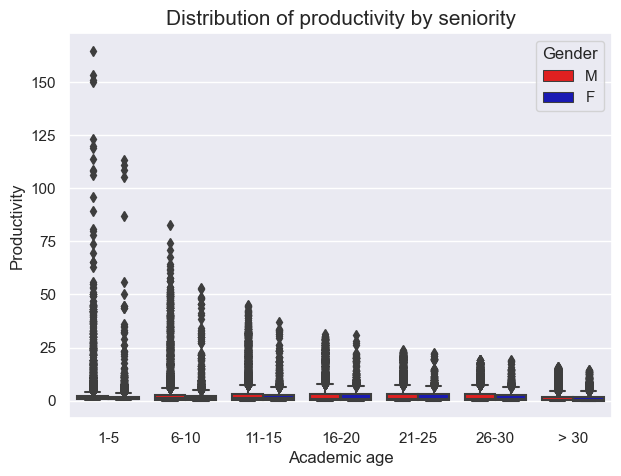

In [140]:
sns.boxplot(data=researchers , x="Seniority_cat", y='Productivity', hue='Gender', palette = ['red', 'mediumblue'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.title("Distribution of productivity by seniority", fontsize = 15)
plt.savefig("Figures/productivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

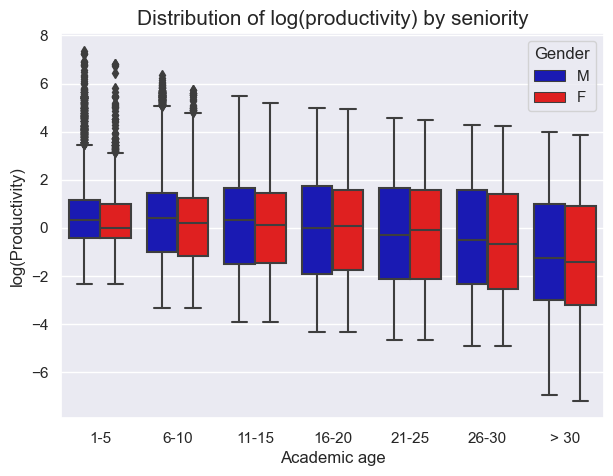

In [141]:
sns.boxplot(data=researchers , x="Seniority_cat", y='log_Productivity', hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("log(Productivity)", fontsize=12)
plt.title("Distribution of log(productivity) by seniority", fontsize = 15)
plt.savefig("Figures/logProductivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

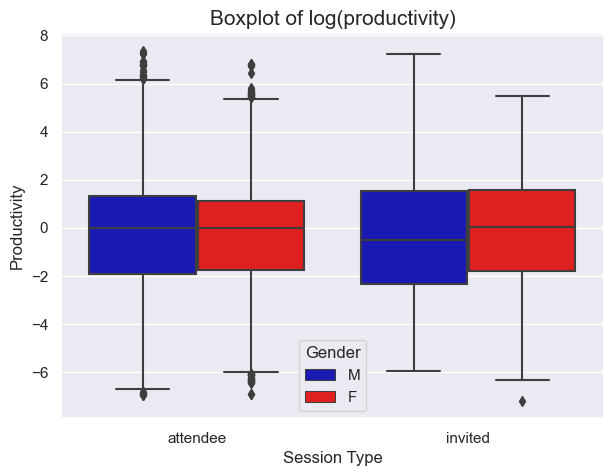

In [142]:
#productivity
sns.boxplot(data=researchers , x="SessionType", y="log_Productivity", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.title("Boxplot of log(productivity)", fontsize = 15)
plt.savefig("Figures/logProductivity_boxplot", bbox_inches='tight')
plt.show()

In [143]:
#FDI: Diversity
#FHPP: Philosopy and history of physics

## Permutation test

In [170]:
def permutationTest(df, labelColumn, attributes, iterations):
    results = {}
    groupedData = df.groupby(labelColumn).mean(numeric_only = True)
    for c in attributes:
        delta = groupedData[c]['F'] - groupedData[c]['M'] #difference in sample mean
        permutationDelta = []
        femaleAvg = []
        maleAvg = []
        for i in range(0, iterations):
            df['Permutation'] = np.random.permutation(df[labelColumn].values)
            groupedData_permutated = df.groupby('Permutation').mean(numeric_only = True)
            delta_permutation = groupedData_permutated[c]['F'] - groupedData_permutated[c]['M'] #difference of current permutation
            permutationDelta.append(delta_permutation)
            femaleAvg.append(groupedData_permutated[c]['F'])
            maleAvg.append(groupedData_permutated[c]['M'])
        results[c] = {'Delta': delta, 'PermutationDelta': permutationDelta, 'FemaleAvg': femaleAvg, 'MaleAvg': maleAvg}
    return results


#something is not working here
#we need to calculate avg 

In [171]:
permutationResults_invited = permutationTest(invited, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
permutationResults_attendees = permutationTest(attendees, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)

In [172]:
permutationResults_invited['Seniority'].keys()
#dict_keys(['Delta', 'PermutationDelta', 'FemaleAvg', 'MaleAvg'])

{'Delta': -1.6656331445512595,
 'PermutationDelta': [0.003999206581294601,
  -0.24222154293658704,
  -0.3483799247829005,
  0.3485970952970696,
  0.010113040090768521,
  -0.3622750009407909,
  0.3669385958254914,
  -0.3239245907450048,
  0.021229101017084417,
  -0.44842447311973643,
  0.09403930008445016,
  0.07903261783392423,
  -0.04880208281869969,
  -0.08715249301448935,
  0.19519545451392162,
  0.026787131480244142,
  0.22632042510760186,
  -0.2099849662502713,
  -0.6073841443660442,
  0.5186728274696932,
  0.38528009635391314,
  -0.1282819184418571,
  0.35860155013075357,
  0.19241643928233998,
  -0.02434674878080756,
  -0.045467264540807406,
  -0.08215026559764738,
  0.2518873652381295,
  -0.012674884808177467,
  0.015115267507610497,
  0.06180272339813442,
  0.07792101174129229,
  -0.5001141564271023,
  0.5848133899812709,
  0.38027786893707116,
  0.0073340248591904356,
  -0.11494264533027732,
  -0.26056304346500525,
  0.8354805638696803,
  -0.04435565844817546,
  -0.1960898900

In [ ]:
how many of 

In [147]:
permutations_inv = pd.DataFrame({'Seniority': permutationResults_invited['Seniority']['PermutationDelta'], 'PaperCount': permutationResults_invited['CumulativePaperCount']['PermutationDelta'], 'Productivity': permutationResults_invited['Productivity']['PermutationDelta']} )
permutations_att = pd.DataFrame({'Seniority': permutationResults_attendees['Seniority']['PermutationDelta'], 'PaperCount': permutationResults_attendees['CumulativePaperCount']['PermutationDelta'], 'Productivity': permutationResults_attendees['Productivity']['PermutationDelta']} )

In [148]:
#calculate p-value
#permutations_inv[permutations_inv.Seniority = ]
#permutationResults_invited['Seniority']['Delta']


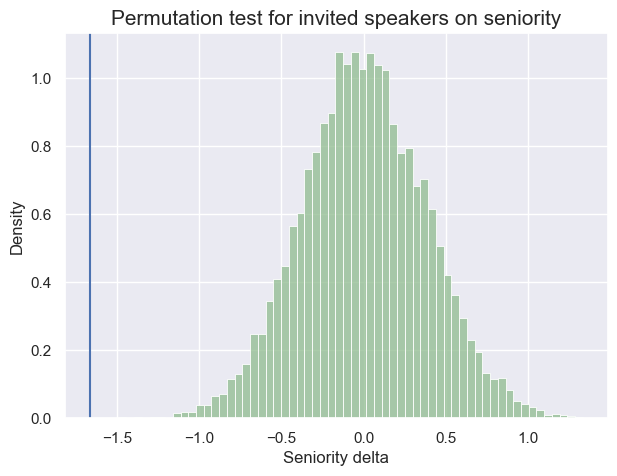

In [149]:
sns.histplot(data = permutations_inv , x = 'Seniority', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_invited['Seniority']['Delta'])
plt.xlabel('Seniority delta', fontsize=12)
plt.title("Permutation test for invited speakers on seniority", fontsize = 15)
plt.savefig("Figures/permutationtest_seniority", bbox_inches='tight')
plt.show()

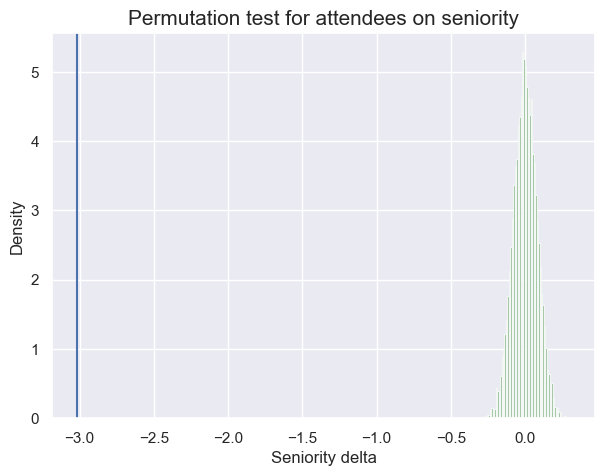

In [150]:
sns.histplot(data = permutations_att , x = 'Seniority', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_attendees['Seniority']['Delta']) 
plt.xlabel('Seniority delta', fontsize=12)
plt.title("Permutation test for attendees on seniority", fontsize = 15)
plt.savefig("Figures/permutationtest_seniority_Attendees", bbox_inches='tight')
plt.show()

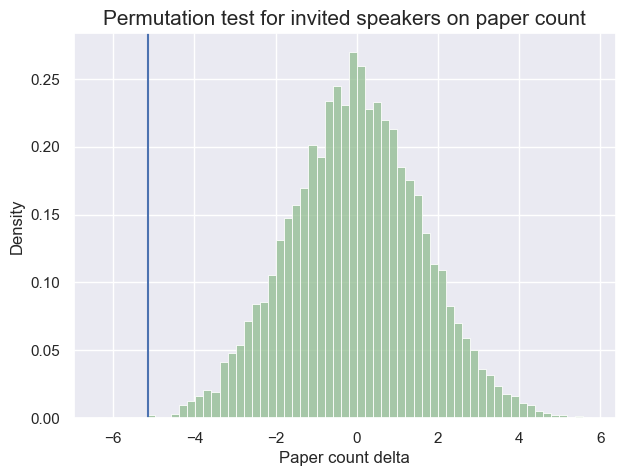

In [151]:
sns.histplot(data = permutations_inv , x = 'PaperCount', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_invited['CumulativePaperCount']['Delta']) 
plt.xlabel('Paper count delta', fontsize=12)
plt.title("Permutation test for invited speakers on paper count", fontsize = 15)
plt.savefig("Figures/permutationtest_cumulativePaperCount", bbox_inches='tight')
plt.show()

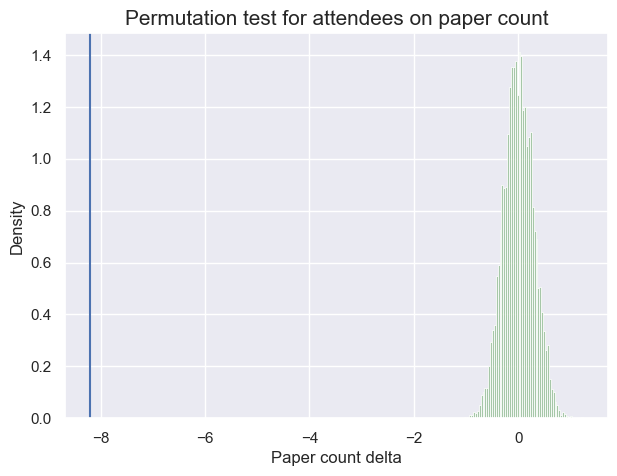

In [152]:
sns.histplot(data = permutations_att , x = 'PaperCount', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_attendees['CumulativePaperCount']['Delta']) 
plt.xlabel('Paper count delta', fontsize=12)
plt.title("Permutation test for attendees on paper count", fontsize = 15)
plt.savefig("Figures/permutationtest_cumulativePaperCount_Attendees", bbox_inches='tight')
plt.show()

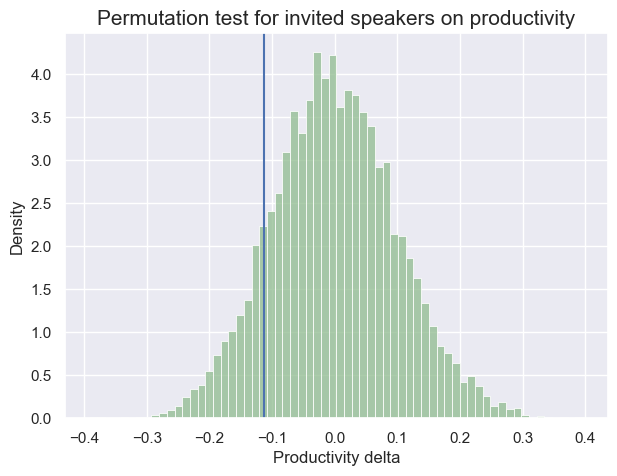

In [153]:
sns.histplot(data = permutations_inv , x = 'Productivity', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_invited['Productivity']['Delta']) 
plt.xlabel('Productivity delta', fontsize=12)
plt.title("Permutation test for invited speakers on productivity", fontsize = 15)
plt.savefig("Figures/permutationtest_productivity", bbox_inches='tight')
plt.show()

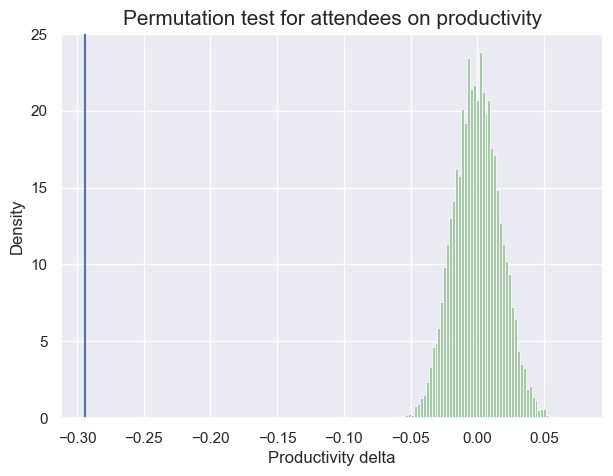

In [154]:
sns.histplot(data = permutations_att , x = 'Productivity', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_attendees['Productivity']['Delta']) 
plt.xlabel('Productivity delta', fontsize=12)
plt.title("Permutation test for attendees on productivity", fontsize = 15)
plt.savefig("Figures/permutationtest_productivity_Attendees", bbox_inches='tight')
plt.show()

In [155]:
#calculate p-values now.
#How many is at empirical mean or more extreme

In [156]:
df = researchers
groupedData = df.groupby('Gender').mean(numeric_only = True)
seniority_empiricalDelta = groupedData['Seniority']['F'] - groupedData['Seniority']['M']
paperCount_empiricalDelta = groupedData['CumulativePaperCount']['F'] - groupedData['CumulativePaperCount']['M']
Productivity_empiricalDelta = groupedData['Productivity']['F'] - groupedData['Productivity']['M']

In [157]:
Productivity_empiricalDelta

-0.2841114655196435

In [158]:
researchers['PermutatedGender'] = np.random.permutation(researchers.Gender.values)
researchers
#SessionType - insteaf of avg. count number of invited
#Seniority, CumulativePaperCount, Productivity

,ID,SearchName,FirstName,AuthorCount,MaxPaperCount,API_Field,API_FieldCount,ExternalField,ModelField,ExternalFieldCount,...,Productivity,firstName,Gender,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,SameField,Seniority_cat,PermutatedGender
1,155001,niels john,niels,6,7,Mathematics,2,Mathematics,Mathematics,2,...,0.700000,niels,M,2.807355,2.807355,-0.514573,2.584963,1,6-10,M
4,155006,luke neal,luke,9,44,Chemistry,29,Chemistry,Chemistry,29,...,1.571429,luke,M,5.459432,3.459432,0.652077,3.169925,1,6-10,M
6,155007,helena hagelin-weaver,helena,6,46,Chemistry,26,Chemistry,Chemistry,26,...,1.916667,helena,F,5.523562,4.523562,0.938599,2.584963,1,11-15,M
7,155010,john boone,john,44,6,Medicine,5,Medicine,Medicine,5,...,0.222222,john,M,2.584963,2.584963,-2.169925,5.459432,1,26-30,M
8,155010,john boone,john,44,6,Medicine,5,Medicine,Medicine,5,...,0.250000,john,M,2.584963,2.000000,-2.000000,5.459432,1,16-20,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504611,35998,sefa dag,sefa,3,2,Materials Science,2,Materials Science,Engineering,2,...,-0.000000,sefa,M,1.000000,-inf,-inf,1.584963,0,NaN,M
504613,35999,kathleen lehman,kathleen,5,6,Computer Science,2,Computer Science,Physics,2,...,1.000000,kathleen,F,2.584963,1.584963,0.000000,2.321928,0,1-5,M
504614,36000,xianwei sha,xianwei,4,40,Chemistry,18,Chemistry,Materials Science,18,...,1.400000,xianwei,M,5.321928,3.807355,0.485427,2.000000,0,6-10,F
504615,36000,xianwei sha,xianwei,4,40,Chemistry,18,Chemistry,Materials Science,18,...,1.636364,xianwei,M,5.321928,4.169925,0.710493,2.000000,0,11-15,M


In [159]:
researchers

,ID,SearchName,FirstName,AuthorCount,MaxPaperCount,API_Field,API_FieldCount,ExternalField,ModelField,ExternalFieldCount,...,Productivity,firstName,Gender,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,SameField,Seniority_cat,PermutatedGender
1,155001,niels john,niels,6,7,Mathematics,2,Mathematics,Mathematics,2,...,0.700000,niels,M,2.807355,2.807355,-0.514573,2.584963,1,6-10,M
4,155006,luke neal,luke,9,44,Chemistry,29,Chemistry,Chemistry,29,...,1.571429,luke,M,5.459432,3.459432,0.652077,3.169925,1,6-10,M
6,155007,helena hagelin-weaver,helena,6,46,Chemistry,26,Chemistry,Chemistry,26,...,1.916667,helena,F,5.523562,4.523562,0.938599,2.584963,1,11-15,M
7,155010,john boone,john,44,6,Medicine,5,Medicine,Medicine,5,...,0.222222,john,M,2.584963,2.584963,-2.169925,5.459432,1,26-30,M
8,155010,john boone,john,44,6,Medicine,5,Medicine,Medicine,5,...,0.250000,john,M,2.584963,2.000000,-2.000000,5.459432,1,16-20,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504611,35998,sefa dag,sefa,3,2,Materials Science,2,Materials Science,Engineering,2,...,-0.000000,sefa,M,1.000000,-inf,-inf,1.584963,0,NaN,M
504613,35999,kathleen lehman,kathleen,5,6,Computer Science,2,Computer Science,Physics,2,...,1.000000,kathleen,F,2.584963,1.584963,0.000000,2.321928,0,1-5,M
504614,36000,xianwei sha,xianwei,4,40,Chemistry,18,Chemistry,Materials Science,18,...,1.400000,xianwei,M,5.321928,3.807355,0.485427,2.000000,0,6-10,F
504615,36000,xianwei sha,xianwei,4,40,Chemistry,18,Chemistry,Materials Science,18,...,1.636364,xianwei,M,5.321928,4.169925,0.710493,2.000000,0,11-15,M
